In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import torch

import meshio
import trimesh
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


True

In [3]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
ds.load_metadata()
ds.load_materials()
ds.load_densities()
pprint(ds)

ShapeNetDataset()
├── root:      PosixPath('../../data/ShapeNetSem')
├── metadata:  DataFrame(shape=(12288, 16))
|   ├── 'fullId':          Series(len=12288, dtype=object)
|   ├── 'category':        Series(len=12288, dtype=object)
|   ├── 'wnsynset':        Series(len=12288, dtype=object)
|   ├── 'wnlemmas':        Series(len=12288, dtype=object)
|   ├── 'up':              Series(len=12288, dtype=object)
|   ├── 'front':           Series(len=12288, dtype=object)
|   ├── 'unit':            Series(len=12288, dtype=float64)
|   ├── 'aligned.dims':    Series(len=12288, dtype=object)
|   ├── 'isContainerLike': Series(len=12288, dtype=float64)
|   ├── 'surfaceVolume':   Series(len=12288, dtype=float64)
|   └── <6 more items>
├── materials: DataFrame(shape=(343, 3))
|   ├── 'Category': Series(len=343, dtype=object)
|   ├── 'Material': Series(len=343, dtype=object)
|   └── 'Ratio':    Series(len=343, dtype=float64)
└── densities: DataFrame(shape=(19, 3))
    ├── 'Material':            Series(l

In [4]:
%autoreload
examples = list(ds.examples())
len(examples)

12288

In [5]:
%autoreload
ex = examples[2]
pprint(ex)

Example()
├── dataset:      'ShapeNet'
├── subject:      'wss.101354f9d8dede686f7b08d9de913afe'
├── variant:      None
├── visit:        None
├── fixed_state:  None
├── moving_state: None
├── paths:        dict(len=3)
|   ├── 'raw_mask': PosixPath('../../data/ShapeNetSem/models-binvox-solid/101354f9d8dede686f7b08d9de913afe.binvox')
|   ├── 'raw_mesh': PosixPath('../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj')
|   └── 'material': PosixPath('../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.mtl')
└── metadata:     dict(len=15)
    ├── 'category':        'Speaker,_Attributes'
    ├── 'wnsynset':        'n3696785'
    ├── 'wnlemmas':        'loudspeaker,speaker,speaker unit,loudspeaker system,speaker system'
    ├── 'up':              nan
    ├── 'front':           nan
    ├── 'unit':            np.float64(0.0136197560186615)
    ├── 'aligned.dims':    '43.43313\\,60.591843\\,32.17259'
    ├── 'isContainerLike': np.float64(nan)
    ├─

In [6]:
def parse_aligned_dims(s: str) -> np.ndarray:
    parts = s.replace('\\,', ',').split(',')
    return np.array([float(p) for p in parts])

def infer_translate(bv_trans, mesh_min, tol=1e-3):
    e_pos = relative_error(bv_trans, +mesh_min)
    e_neg = relative_error(bv_trans, -mesh_min)
    if min(e_pos, e_neg) < tol:
        return +1 if e_pos < e_neg else -1
    return 0 # unknown

def infer_scale(bv_scale, mesh_scale, tol=1e-3):
    e_eq  = relative_error(bv_scale, mesh_scale * 1.0)
    e_inv = relative_error(bv_scale * mesh_scale, 1.0)
    if min(e_eq, e_inv) < tol:
        return +1 if e_eq < e_inv else -1
    return 0 # unknown

def relative_error(a, b, eps=1e-12):
    return np.linalg.norm(a - b) / (np.linalg.norm(b) + eps)

def build_affine_matrix(spacing, origin):
    sx, sy, sz = spacing
    ox, oy, oz = origin
    return np.array([
        [sx, 0., 0., ox],
        [0., sy, 0., oy],
        [0., 0., sz, oz],
        [0., 0., 0., 1.],
    ], dtype=float)

def cleanup_binary_mask(array):
    import skimage.morphology
    from project.preprocessing import segmentation
    filtered = segmentation.filter_connected_components(array.astype(int), max_components=1)
    return skimage.morphology.binary_dilation(filtered).astype(array.dtype)


In [7]:
import meshio
import binvox

# load binary mask from binvox file
bv = binvox.Binvox.read(ex.paths['raw_mask'], mode='dense')
bv_array = cleanup_binary_mask(bv.numpy()).astype(int)

# load object mesh and compute bbox
io_mesh = meshio.read(ex.paths['raw_mesh'])
io_mesh_min = io_mesh.points.min(axis=0)
io_mesh_max = io_mesh.points.max(axis=0)
io_mesh_extent = (io_mesh_max - io_mesh_min).max()

# build binvox affine (voxel -> model coords) from mesh bbox
bv_spacing = 1 / np.asarray(bv_array.shape) * io_mesh_extent
bv_origin  = 0.5 * bv_spacing + io_mesh_min
bv_affine  = build_affine_matrix(bv_spacing, bv_origin)
bv_affine

  # 1-connected inputs components: 4
    3 voxels were dropped (0.0004%)
  # 1-connected output components: 1


array([[ 0.34756406,  0.        ,  0.        ,  0.17378203],
       [ 0.        ,  0.34756406,  0.        , -0.21991897],
       [ 0.        ,  0.        ,  0.34756406,  0.17378203],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
%autoreload
fig = project.visual.matplotlib.show_image_slices(bv_array, cmap='binary')

In [52]:
import pyvista as pv

# check alignment using pyvista
pv_mesh = pv.wrap(io_mesh)
pv_grid = pv.ImageData(
    dimensions=bv_array.shape,
    spacing=bv_spacing,
    origin=bv_origin
)
pv_grid.point_data['bv'] = bv_array.flatten(order='F')
pv_grid

ImageData (0x14b76f9d1900)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     1.738e-01, 4.431e+01
  Y Bounds:     -2.199e-01, 4.392e+01
  Z Bounds:     1.738e-01, 4.431e+01
  Dimensions:   128, 128, 128
  Spacing:      3.476e-01, 3.476e-01, 3.476e-01
  N Arrays:     1

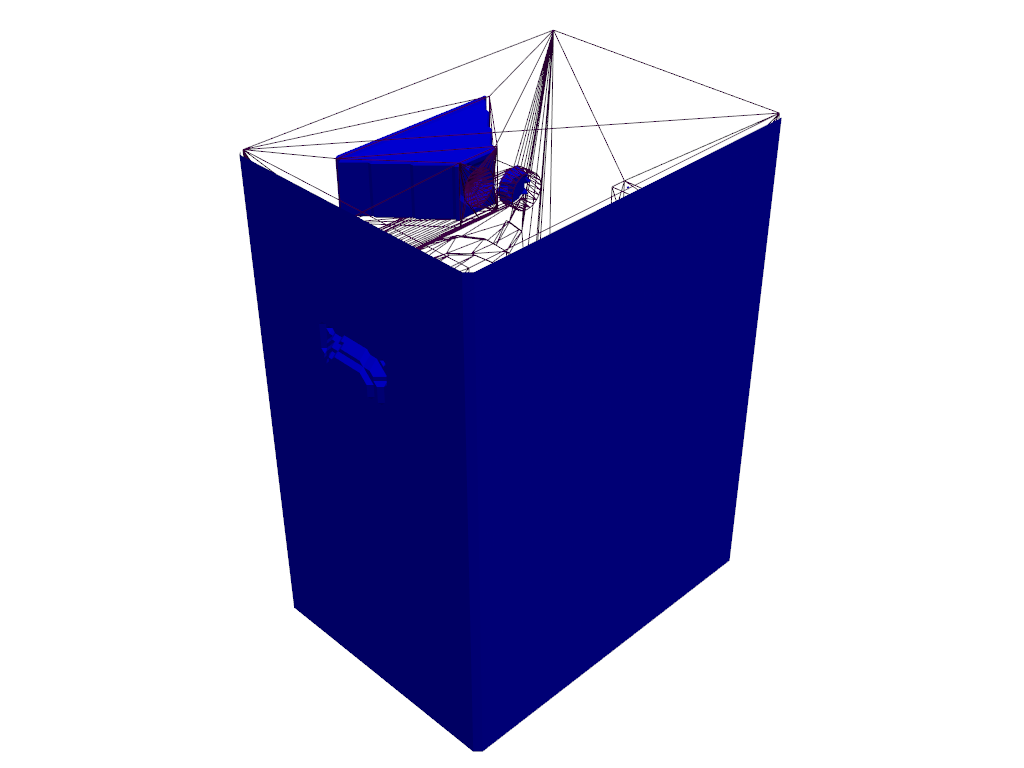

In [56]:
p = pv.Plotter()
iso = pv_grid.contour(0.5, scalars='bv')
p.add_mesh(iso, color='blue')
p.add_mesh(pv_mesh, style='wireframe', show_scalar_bar=False)
p.show(jupyter_backend='static')

In [57]:
import trimesh
from pathlib import Path

class ShapeNetResolver(trimesh.resolvers.Resolver):
    '''
    Trimesh path resolver for ShapeNet assets.
    '''
    def __init__(self, data_root):
        self.root = Path(data_root)
        self.obj_root = self.root / 'models-OBJ' / 'models'
        self.tex_root = self.root / 'models-textures' / 'textures'

    def get_path(self, name):
        name = str(name).strip().replace('\\', '/').lstrip('/')
        ext = os.path.splitext(name)[1].lower()
        if ext in {'.obj', '.mtl'}:
            return self.obj_root / name
        elif ext in {'.jpg', '.jpeg', '.png'}:
            return self.tex_root / name
        else:
            return name

    def get(self, name):
        print('get', name)
        path = self.get_path(name)
        data = path.read_bytes()
        return data

    def write(self, name, data):
        print('write', name, data)
        raise NotImplementedError

    def namespaced(self, namespace):
        print('namespaced', namespace)
        raise NotImplementedError

    def keys(self):
        print('keys')
        raise NotImplementedError

scene = trimesh.load_scene(
    ex.paths['raw_mesh'],
    resolver=ShapeNetResolver(ds.root),
    group_material=True,
    skip_materials=False
)
pprint(scene)

get 101354f9d8dede686f7b08d9de913afe.mtl
get 007749519811e17c.jpg
Scene()
├── geometry: OrderedDict(len=7)
|   ├── 'm5': Trimesh()
|   ├── 'm2': Trimesh()
|   ├── 'm3': Trimesh()
|   ├── 'm6': Trimesh()
|   ├── 'm1': Trimesh()
|   ├── 'm0': Trimesh()
|   └── 'm4': Trimesh()
├── graph:    SceneGraph()
|   ├── transforms:   EnforcedForest()
|   ├── base_frame:   'world'
|   └── repair_rigid: 1e-05
└── metadata: dict(len=0)


In [65]:
def assign_region_labels(mask, scene, affine):

    parts = []
    for name, geo in sorted(scene.geometry.items()):
        v = geo.vertices.copy()
        f = geo.faces.copy()
        parts.append((v, f))

    verts = []
    faces = []
    labels = []

    offset = 0
    for i, (v, f) in enumerate(parts):
        verts.append(v)
        faces.append(f + offset)
        labels.append(np.full(len(f), i, dtype=np.int16))
        offset += len(v)

    verts = np.concatenate(verts, axis=0)
    faces = np.concatenate(faces, axis=0)
    labels = np.concatenate(labels, axis=0)

    mesh = trimesh.Trimesh(
        vertices=verts,
        faces=faces,
        process=False
    )
    I, J, K = np.nonzero(mask)
    points_voxel = np.c_[I, J, K]
    points_model = project.core.transforms.voxel_to_world_coords(points_voxel, affine)

    pq = trimesh.proximity.ProximityQuery(mesh)
    N = len(points_model)
    batch_size = 50000
    nearest_faces = np.empty(N, dtype=np.int32)

    for i in range(0, N, batch_size):
        print(f'{i} / {N}')
        p, d, f = pq.on_surface(points_model[i:i+batch_size])
        nearest_faces[i:i+batch_size] = f

    labeled = np.zeros(mask.shape, dtype=np.int16)
    labeled[I, J, K] = labels[nearest_faces] + 1
    return labeled
    
    # TODO

label_array = assign_region_labels(bv_array, scene, bv_affine)
label_array

0 / 812739
50000 / 812739
100000 / 812739
150000 / 812739
200000 / 812739
250000 / 812739
300000 / 812739
350000 / 812739
400000 / 812739
450000 / 812739
500000 / 812739
550000 / 812739
600000 / 812739
650000 / 812739
700000 / 812739
750000 / 812739
800000 / 812739


array([[[1, 1, 1, ..., 1, 1, 1],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 3, 3, ..., 3, 3, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [66]:
np.unique(label_array)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int16)

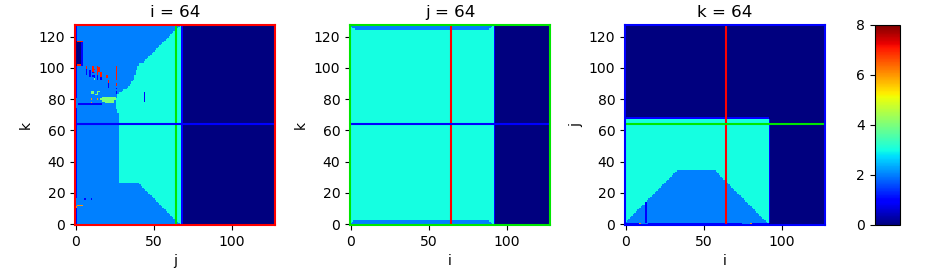

In [100]:
%autoreload
fig = project.visual.matplotlib.show_image_slices(
    label_array, cmap='jet', clim=(0, 8)
)

In [111]:
counts = np.unique(label_array, return_counts=True)[1]
counts

array([1284413,   35275,  347953,  422774,    3401,     479,     482,
          2375])

In [189]:
opacity = np.minimum(1, np.max(counts[1:]) / counts * 0.01)

for i, c in enumerate(counts):
    p = c / counts.sum()
    o = opacity[i]
    print(f'label = {i}    count = {c}\tp = {p * 100:.2f}%\t o = {o:f}')

label = 0    count = 1284413	p = 61.25%	 o = 0.003292
label = 1    count = 35275	p = 1.68%	 o = 0.119851
label = 2    count = 347953	p = 16.59%	 o = 0.012150
label = 3    count = 422774	p = 20.16%	 o = 0.010000
label = 4    count = 3401	p = 0.16%	 o = 1.000000
label = 5    count = 479	p = 0.02%	 o = 1.000000
label = 6    count = 482	p = 0.02%	 o = 1.000000
label = 7    count = 2375	p = 0.11%	 o = 1.000000


In [190]:
pv_grid.point_data['label'] = label_array.flatten(order='F')

p = pv.Plotter()
p.add_volume(
    pv_grid,
    scalars='label',
    cmap='jet',
    clim=(0, 8),
    opacity=opacity
)
p.enable_depth_peeling(10)
p.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14b72fceae90_28" src="https://ondemand.bridges2.…

In [ ]:
def process_region_mask(input_array):
    return input_array

ret = process_region_mask(label_array)

fig = project.visual.matplotlib.show_image_slices(
    ret, cmap='jet', clim=(0, 8)
)